In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
data = pd.read_csv('wholesale_data.csv')
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [3]:
data.shape

(440, 8)

In [4]:
for col in data.columns:
    null_values = data.loc[data[col] == pd.isnull, data.columns].empty
    if not null_values:
        print(data.loc[data[col] == pd.isnull, data.columns])

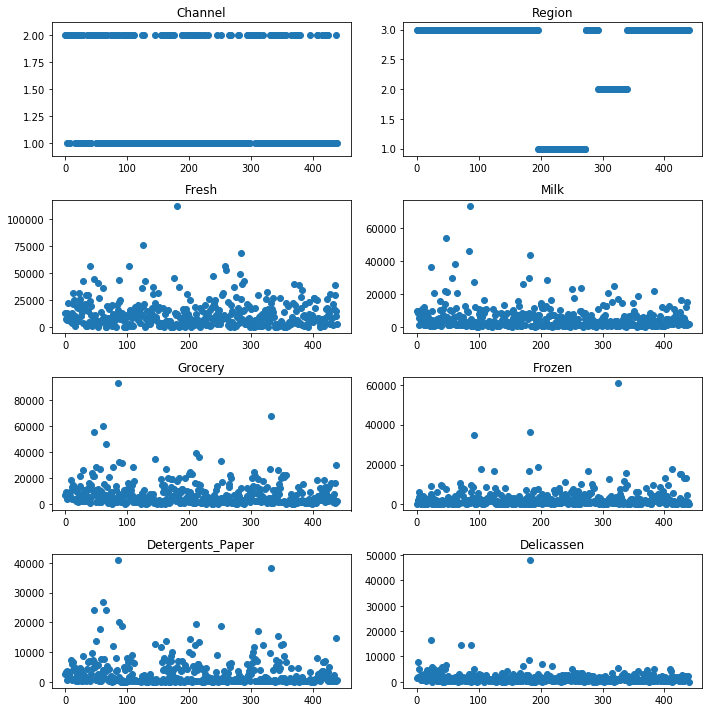

In [5]:
for i, col in enumerate(data.columns.values):
    plt.subplot(4, 2, i+1)
    plt.scatter([i for i in range(440)], data[col].values.tolist())
    plt.title(col)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

In [6]:
train = data.drop(['Region', 'Channel'], axis=1)
train.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [7]:
train.shape

(440, 6)

In [8]:
log_data = np.log(train)
good_data = log_data.drop([128, 65, 66, 75, 154])
print(good_data.head())

       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0   9.446913  9.175335  8.930759  5.365976          7.891331    7.198931
1   8.861775  9.191158  9.166179  7.474205          8.099554    7.482119
2   8.756682  9.083416  8.946896  7.785305          8.165079    8.967504
3   9.492884  7.086738  8.347827  8.764678          6.228511    7.488853
4  10.026369  8.596004  8.881558  8.272571          7.482682    8.553525


In [9]:
from sklearn.decomposition import PCA
help(PCA)

Help on class PCA in module sklearn.decomposition.pca:

class PCA(sklearn.decomposition.base._BasePCA)
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of components to keep.
 |      if n_components is not set all components are kept::
 |  
 |          n_components == min(n_samples, n

In [10]:
pca = PCA().fit(good_data)
print(pca.explained_variance_ratio_)
print()
print(good_data.columns.values.tolist())
print(pca.components_)

[ 0.44302505  0.26379218  0.1230638   0.10120908  0.04850196  0.02040793]

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
[[ 0.16746374 -0.40143866 -0.43811142  0.17820975 -0.75142613 -0.14987105]
 [-0.68593522 -0.16722783 -0.07072902 -0.50054207 -0.04244398 -0.49414702]
 [-0.67738927  0.04020501 -0.01953317  0.31504299 -0.21170161  0.62855082]
 [-0.204293    0.01281068  0.05567564  0.78544905  0.20961368 -0.54233972]
 [-0.00261356  0.71923846  0.3553861  -0.0330861  -0.55815441 -0.20918629]
 [ 0.02915623 -0.54018269  0.82053348  0.02054106 -0.18238824  0.01974794]]


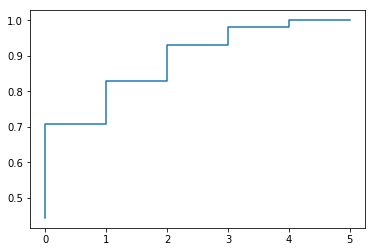

In [11]:
# http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.step([i for i in range(len(cumulative))], cumulative)
plt.show()

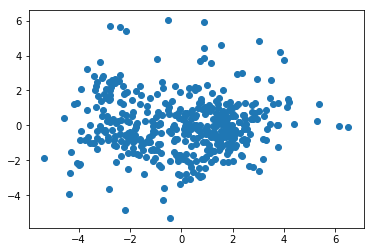

In [12]:
pca = PCA(n_components=2)
pca.fit(good_data)
reduced_data = pca.transform(good_data)
plt.scatter([row[0] for row in reduced_data], [row[1] for row in reduced_data])
plt.show()

In [13]:
reduced_data = pd.DataFrame(reduced_data, columns=['Dim1', 'Dim2'])

### K-Means

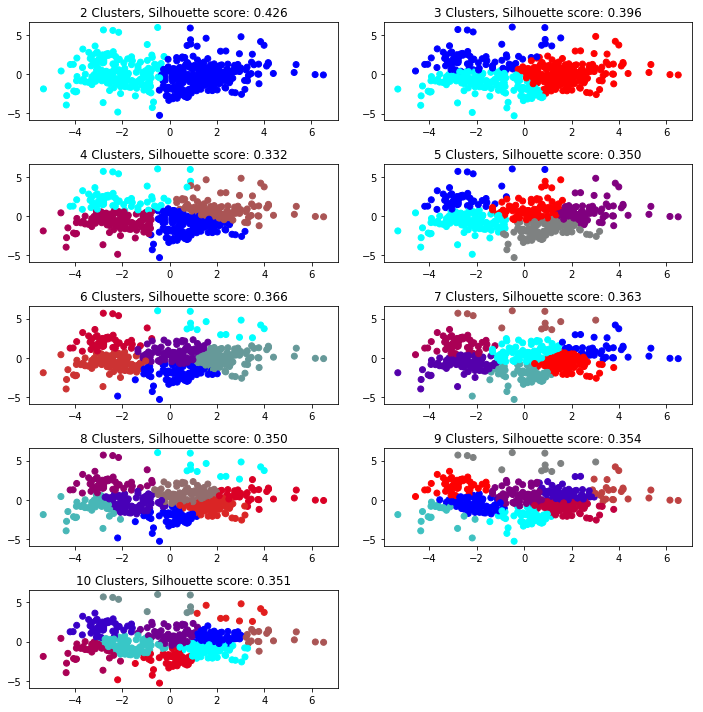

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('BlRd', ['blue', 'red', 'cyan'])

silhouette_scores = []
for i in range(2, 11):
    cl = KMeans(n_clusters=i, random_state=0)
    result = cl.fit_predict(reduced_data)
    silhouette = silhouette_score(reduced_data, result)
    silhouette_scores.append(silhouette)
    plt.subplot(5, 2, i-1)
    plt.scatter(reduced_data.Dim1.values, reduced_data.Dim2.values, c=result, cmap=cmap)
    plt.title(str(i) + ' Clusters, Silhouette score: ' + str(silhouette)[:5])
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

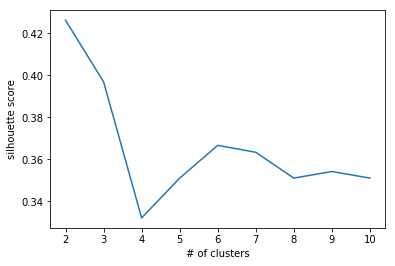

In [15]:
plt.plot([i for i in range(2, 11)], silhouette_scores)
plt.xlabel('# of clusters')
plt.ylabel('silhouette score')
plt.show()

## Hierarchical Clustering

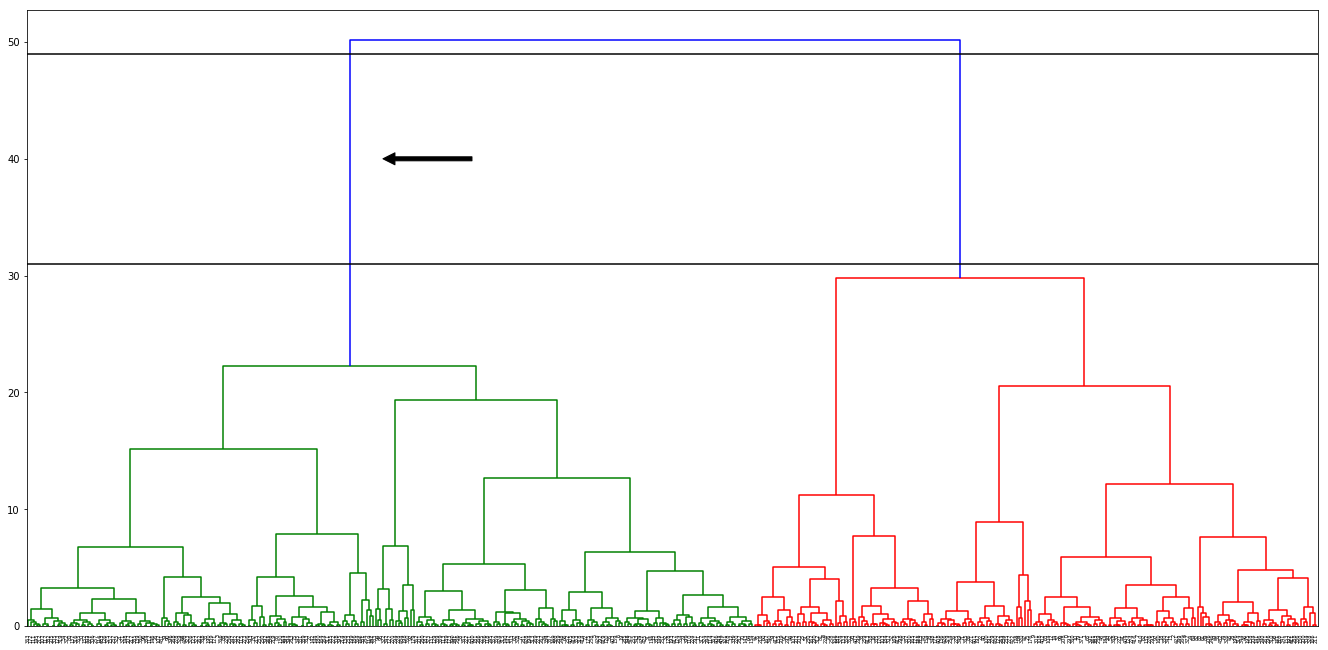

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram

cl = linkage(reduced_data, method='ward')
fig, ax = plt.gcf(), plt.gca()
dn = dendrogram(cl, truncate_mode='level', p=15)
plt.tight_layout()
fig.set_size_inches(20, 10)
plt.axhline(y=31, c='k')
plt.axhline(y=49, c='k')
ax.annotate('', xy=(1200, 40), xytext=(1500, 40),
           arrowprops={'facecolor': 'black'})
plt.show()

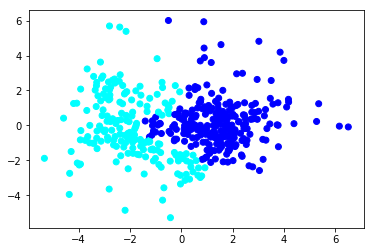

In [17]:
from scipy.cluster.hierarchy import fcluster
labels = fcluster(cl, 2, criterion='maxclust')
plt.scatter(reduced_data.Dim1.values.tolist(),
           reduced_data.Dim2.values.tolist(),
           cmap=cmap,
           c=labels)
plt.show()

## DBSCAN

In [53]:
cl = DBSCAN(eps=eps, min_samples=min_samples)
result = cl.fit_predict(reduced_data)


4

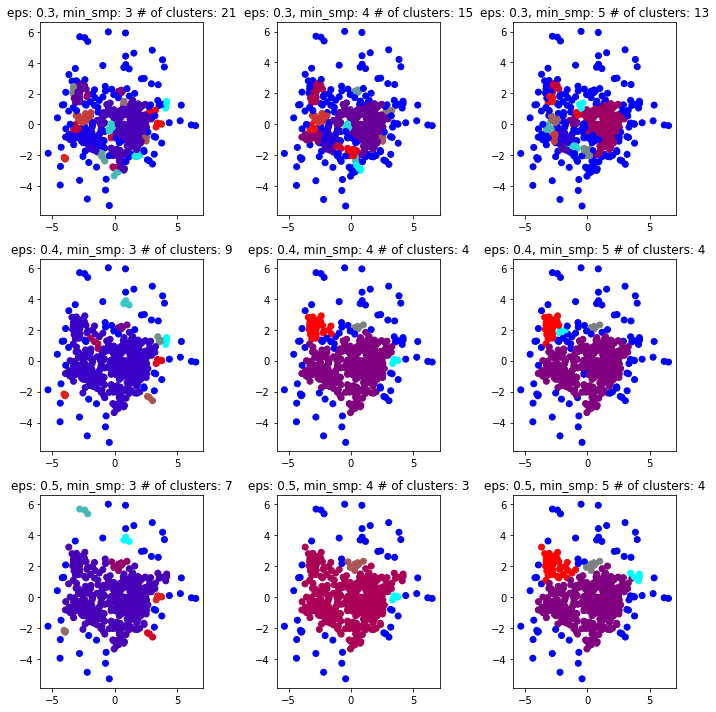

In [55]:
from sklearn.cluster import DBSCAN

plot_id = 0
for eps in np.arange(0.3, 0.6, 0.1):
    for min_samples in range(3, 6):
        plot_id += 1
        cl = DBSCAN(eps=eps, min_samples=min_samples)
        result = cl.fit_predict(reduced_data)
        n_clusters = len([c for c in list(set(result)) if c != -1])
        plt.subplot(3, 3, plot_id)
        plt.scatter(reduced_data.Dim1.values.tolist(),
           reduced_data.Dim2.values.tolist(),
           cmap=cmap,
           c=result
        )
        fig, ax = plt.gcf(), plt.gca()
        fig.set_size_inches(10, 10)
        plt.title('eps: ' + str(eps) +\
                  ', min_smp: ' + str(min_samples) +\
                 ' # of clusters: ' + str(n_clusters))
        plt.tight_layout()
plt.show()